<a href="https://colab.research.google.com/github/MmV0/Home-Credit-Default-Risk/blob/main/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt # for plotting

import sklearn.model_selection 

# For GDrive 
from google.colab import drive

# File system manangement
import os

import plotly.graph_objs as go

import plotly.offline as py
from plotly.offline import iplot

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

#**Data pre-processing**

###**1. Importing dataset**

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Home_Credit_Default_Risk-DAAI/Data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#app_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Home_Credit_Default_Risk-DAAI/Data/application_train.csv')
#app_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Home_Credit_Default_Risk-DAAI/Data/application_test.csv')
#app_test.set_index('SK_ID_CURR', inplace=True)
#app_train.set_index('SK_ID_CURR', inplace=True)

In [ ]:
# List available files
print(os.listdir(path))

['HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'previous_application.csv', 'sample_submission.csv']


In [ ]:
# Improting Training data
app_train = pd.read_csv (path + '/application_train.csv')
print('Training data shape: ', app_train.shape)

Training data shape:  (307511, 122)


In [ ]:
# Importing Testing data
app_test = pd.read_csv (path + '/application_test.csv')
print('Test data shape: ', app_test.shape)

Test data shape:  (48744, 121)


In [ ]:
app_test.set_index('SK_ID_CURR', inplace=True)
app_train.set_index('SK_ID_CURR', inplace=True)

### **2. Data exploration**

In [ ]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


Manual verification that categorical are indeed categorical

In [ ]:
categorical_feats = [ f for f in app_train.columns if app_train[f].dtype == 'object']
print("Number of categorical featurs:", len(categorical_feats), "\n")
for cat in categorical_feats:
  print(set(app_train[cat]))

Number of categorical featurs: 16 

{'Cash loans', 'Revolving loans'}
{'M', 'XNA', 'F'}
{'Y', 'N'}
{'Y', 'N'}
{nan, 'Family', 'Group of people', 'Spouse, partner', 'Unaccompanied', 'Other_A', 'Children', 'Other_B'}
{'Unemployed', 'Working', 'Commercial associate', 'Pensioner', 'Maternity leave', 'Student', 'Businessman', 'State servant'}
{'Secondary / secondary special', 'Incomplete higher', 'Academic degree', 'Lower secondary', 'Higher education'}
{'Civil marriage', 'Widow', 'Unknown', 'Separated', 'Married', 'Single / not married'}
{'Rented apartment', 'Co-op apartment', 'With parents', 'House / apartment', 'Office apartment', 'Municipal apartment'}
{nan, 'Private service staff', 'Secretaries', 'Cooking staff', 'Low-skill Laborers', 'Core staff', 'Security staff', 'Sales staff', 'Cleaning staff', 'Managers', 'HR staff', 'IT staff', 'Medicine staff', 'Accountants', 'Realty agents', 'Laborers', 'High skill tech staff', 'Waiters/barmen staff', 'Drivers'}
{'MONDAY', 'TUESDAY', 'THURSDAY'

In [ ]:
app_train.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,

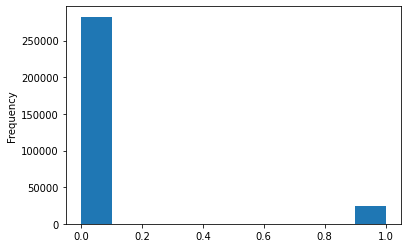

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

In [ ]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

verificare relazione (istogramma) con età, tipo di loan, income, occupation

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [ ]:
# Extracting categorical and numerical features with list comprehension
categorical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'object'])
numerical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'int64' or app_train[f].dtype == 'float64' if f != 'TARGET'])

### **3. Handling Missing Data**

In [ ]:
def missing_values_table(data):
    
    # Total missing values
    total_nan = data.isnull().sum()
    total_xna = data.isin(['XNA']).sum()
    total_mis_val = total_nan + total_xna

    # Percentage of missing values
    percent_mis_val = (data.isnull().sum()/len(data)*100).round(2)

    # Make a table with the results and naming columns 
    table_mis_val = pd.concat([total_mis_val, percent_mis_val], axis=1, keys=['Total_mis_val', 'Percent_mis_val'])

    # Sort the table by total of missing descending
    table_mis_val.sort_values('Total_mis_val', inplace = True, ascending=False)

    # Return the dataframe with missing information
    return table_mis_val

In [ ]:
def Nan_variables(data):
  na_values_number = []
  l_idx_b = []
  # Filling at the beginning with all zeros
  data['BINARY_NAN'] = 0 
  for idx in data.index:
    row = data.loc[idx]
    na_values = row.isna()
    sum_na = na_values.sum()
    na_values_number.append(sum_na)

  # Storing 1 when more than 45 nan in the row
  print("Number of rows with 30 NAN: ", len(data.loc[np.array(na_values_number) > 30]))
  print("Number of rows with 35 NAN: ", len(data.loc[np.array(na_values_number) > 35]))
  print("Number of rows with 40 NAN: ", len(data.loc[np.array(na_values_number) > 40]))
  print("Number of rows with 45 NAN: ", len(data.loc[np.array(na_values_number) > 45]))
  print("Number of rows with 50 NAN: ", len(data.loc[np.array(na_values_number) > 50]))
  data.loc[np.array(na_values_number) > 45, 'BINARY_NAN'] = 1 
  
  # New variable with the sum of the NAN for each row
  data['SUM_NAN'] = na_values_number  

  return data

In [ ]:
def HandlingMissingData(data_train, data_test, binary = False):
  
  # Replace XNA with nan
  data_train[categorical_features] = data_train[categorical_features].apply(lambda x:x.replace("XNA", np.nan))
  data_test[categorical_features] = data_test[categorical_features].apply(lambda x:x.replace("XNA", np.nan))

  # If we want to add the binary custom featuee to exploit NaN information
  if binary: 
    data_train = Nan_variables(data_train)
    data_test = Nan_variables(data_test)

  # Replace Categorical missing values with mode
  data_train[categorical_features] = data_train[categorical_features].apply(lambda x:x.fillna(x.value_counts().index[0]))
  data_test[categorical_features] = data_test[categorical_features].apply(lambda x:x.fillna(x.value_counts().index[0]))

  # Replace Numerical missing values with column mean
  data_train[numerical_features] = data_train[numerical_features].apply(lambda x:x.fillna(x.mean()))
  data_test[numerical_features] = data_test[numerical_features].apply(lambda x:x.fillna(x.mean()))

  return data_train, data_test

###**4. Encoding** 

####**Clustering**

In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

def categorical_clustering(data, var):

  cluster = data.groupby(var).mean()
  variables = cluster.values
  cat_class = cluster.index.values
  
  # Create a normalizer: normalizer
  normalizer = Normalizer()

  # Create a KMeans model with 10 clusters: kmeans
  kmeans = KMeans(n_clusters=5)

  # Make a pipeline chaining normalizer and kmeans: pipeline
  pipeline = make_pipeline(normalizer, kmeans)

  # Fit pipeline to the daily price movements
  pipeline.fit(variables)

  # Predict the cluster labels: labels
  labels = pipeline.predict(variables)

  # Create a DataFrame aligning labels and companies: df
  df = pd.DataFrame({'labels': labels, var: cat_class})

  return df

In [ ]:
def categorical_class_merging(data_train, data_test, categorical_features):
  list_clustered = [] 
  for var in categorical_features:
    # We want at most 5 classes for each categorical variables
    if len(data_train[var].unique()) > 5:
      list_clustered.append(var)
      # We recall the function above for clustering categorical features
      df = categorical_clustering(data_train, var)
      d = {}
      l_unique = df["labels"].unique()
      for x in l_unique:
        l1 = []
        for i in range(len(df)):
          c = df.iloc[i]
          if c["labels"] == x:
            l1.append(c[var])
        
        for el in l1:
          d[el] = x

      data_train[var] = data_train[var].map(d)
      data_test[var] = data_test[var].map(d)

  return data_train, data_test, list_clustered

####**Encoding of Categorical Features**

In [ ]:
def label_encode(data_train, data_test) : 
    le = LabelEncoder()
    for col in data_train:
        if data_train[col].dtype == 'object' and col != 'TARGET':
            if len(data_train[col].unique()) <= 2:
                le.fit(data_train[col])
                data_train[col] = le.transform(data_train[col])  
                data_test[col] = le.transform(data_test[col])
    
    return data_train, data_test

def one_hot_encode(data_train, data_test) :
  
    data_train = pd.get_dummies(data_train)
    data_test = pd.get_dummies(data_test)
    
    return data_train, data_test

def align_train_test(data_train, data_test) :

    train_labels = data_train['TARGET']
    data_train, data_test = data_train.align(data_test, join = 'inner', axis = 1)
    data_train['TARGET'] = train_labels
    
    return train_labels, data_train, data_test

#**Feature engineering**

####**Statistical features**

In [ ]:
def Adding_statistical_features(data_train, data_test):
  data_train['CREDIT_INCOME_PERCENT'] = data_train['AMT_CREDIT'] / data_train['AMT_INCOME_TOTAL']
  data_train['CREDIT_TERM'] = data_train['AMT_ANNUITY'] / data_train['AMT_CREDIT']
  data_test['CREDIT_INCOME_PERCENT'] = data_test['AMT_CREDIT'] / data_test['AMT_INCOME_TOTAL']
  data_test['CREDIT_TERM'] = data_test['AMT_ANNUITY'] / data_test['AMT_CREDIT']

  return data_train, data_test

####**Correlation Matrix for Polynomial Features**

In [ ]:
def Correlation(data):
  
  data['TARGET'] = data['TARGET'].astype(int)
  # Find correlations with the target and sort
  correlations = data.corr()['TARGET']
  
  # removing correlation with same variable and sorting
  correlations = correlations.drop('TARGET')
  # We take the absolute value of correlations because we will base the construction on polynomial features on the top 5 most correlated features
  abs_correlation = abs(correlations).sort_values(ascending=False)

  return correlations, abs_correlation

####**Polynomial features**

In [ ]:
#we can add custom feature in three ways: computing only polynomials features, computing only interactions between feature or both of them

def adding_polyonomials(data_train, data_test, degree, polynomial_variables, polynomials_only= False, interactions_only= False):

  # We take only the first five numerical variables most important
  polynomial_variables = polynomial_variables[:5]
  polynomial_feature_train = data_train[polynomial_variables]
  polynomial_feature_test = data_test[polynomial_variables]
  #only polynomials
  if polynomials_only: 

    pp_train_data = np.hstack((polynomial_feature_train**(i+1) for i in range(degree)))
    pp_test_data = np.hstack((polynomial_feature_test**(i+1) for i in range(degree)))
    # list of new indexes of polyonomials features
    poly_name = [] 
    for i in range(2, 3+1):
      for name in polynomial_variables:
        new_poly_name = name + '^' + str(i)
        poly_name.append(new_poly_name)
    # Now we store the new names of only polynomials features
    new_poly_indexes = polynomial_variables + poly_name 

    pp_train = pd.DataFrame(pp_train_data, columns = new_poly_indexes)
    pp_test = pd.DataFrame(pp_test_data, columns = new_poly_indexes)
    
  else:

    if interactions_only: # only interactions
      poly_transformer = PolynomialFeatures(interaction_only=True)
  
    else:  #both of them, polynomials and interactions
      poly_transformer = PolynomialFeatures(degree = degree)


    poly_transformer.fit(polynomial_feature_train)
    polynomial_feature_train = poly_transformer.transform(polynomial_feature_train)
    polynomial_feature_test = poly_transformer.transform(polynomial_feature_test)

    pp_train = pd.DataFrame(polynomial_feature_train, columns = poly_transformer.get_feature_names(polynomial_variables))
    pp_train.drop('1', axis = 1, inplace = True)
    pp_test = pd.DataFrame(polynomial_feature_test, columns = poly_transformer.get_feature_names(polynomial_variables))
    pp_test.drop('1', axis = 1, inplace = True)

    return pp_train, pp_test 

In [ ]:
def Merging_polynomials_and_interactions(data_train, data_test, data_pp_train, data_pp_test):

  app_train.reset_index(inplace = True)
  app_test.reset_index(inplace = True)
  pp_train['SK_ID_CURR'] = app_train['SK_ID_CURR']
  pp_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
  data_train_poly = app_train.merge(pp_train, on = 'SK_ID_CURR', how = 'left')
  data_test_poly = app_test.merge(pp_test, on = 'SK_ID_CURR', how = 'left')
  data_train_poly.set_index('SK_ID_CURR', inplace = True)
  data_test_poly.set_index('SK_ID_CURR', inplace = True)

  return data_train_poly, data_test_poly


####**Features Selection with Random Forest** 

We select variables in order to don't fall in overfitting using weak learner as logistic regression or SVM instead of more powerfull alghorthm such as Random Forest 

In [ ]:
def Plot_feature_importances(features, importances):

  x, y = (list(x) for x in zip(*sorted(zip(importances, features), 
                                                            reverse = False)))
  trace2 = go.Bar(
      x=x ,
      y=y,
      marker=dict(
          color=x,
          colorscale = 'Viridis',
          reversescale = True
      ),
      name='Random Forest Feature importance',
      orientation='h',
  )

  layout = dict(
      title='Barplot of Feature importances',
      width = 900, height = 2000,
      yaxis=dict(
          showgrid=False,
          showline=False,
          showticklabels=True,
  #         domain=[0, 0.85],
      ),
      margin=dict(
      l=300,
  ),
  )

  fig1 = go.Figure(data=[trace2])
  fig1['layout'].update(layout)

  return print(py.iplot(fig1, filename='plots'))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def Random_forest_classifier(data_train, max_depth):

  rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=4, max_features=0.5, random_state=2018)

  features = data_train.columns.drop('TARGET')

  rf.fit(data_train[features], data_train.TARGET)

  importances = rf.feature_importances_

  plotting = input("Write 'T' if you want the feature' importance plot:  ")

  if plotting == 'T':

    Plot_feature_importances(features, importances)

  return features, importances

In [ ]:
def Selecting_variables(data_train, max_depth):

  # Correlation with target variable
  correlations = data_train.corr()['TARGET'] 
  correlations.drop('TARGET', inplace = True)

  # Running a Random Forest Classifier to extract feature' importances
  features, importances = Random_forest_classifier(data_train, max_depth)
  # Storing all feature importances in classifing target variable and correlations with the latter in a frame
  variable_importance = pd.DataFrame({'Importances': importances, 'Correlations' : correlations}, index = data_train.drop('TARGET', axis = 1).columns)
  variable_importance = variable_importance.sort_values(by = 'Importances', ascending=False)

  return variable_importance

#### **Feature Scaling**

In [ ]:
# Numerical scaling
def scaling(data_train, data_test):
  
  #labels = data_train["TARGET"]
  #data_train.drop("TARGET", axis=1)

  scaler = MinMaxScaler(feature_range = (0, 1))
  scaler.fit(data_train[:])

  #[:] are used in order to mantain the object type a Dataframe, without need to convert a np array
  data_train[:] = scaler.transform(data_train[:]) 
  data_train[:] = scaler.transform(data_train[:])
  #data_train["TARGET"] = labels

  return data_train, data_test

# **ML Models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

def classify(train, test, train_labels, classifier = 'logistic', cv = 5, param_grid = {}, n_jobs = 1, weights=None) :
    
    # aggiungere class weight lezione 10

    # Pick the classifier desired by the user...
    model = LogisticRegression
    if classifier == 'tree' : model = DecisionTreeClassifier(class_weight=weights)
    elif classifier == 'SVC' : model = SVC(class_weight=weights)
    elif classifier == 'rf' : model = RandomForestClassifier(class_weight=weights)
    elif classifier == 'lgbm' : model = LGBMClassifier(class_weight=weights)
    else : pass


    # Setup the grid search. 
    from sklearn.model_selection import GridSearchCV
    search = GridSearchCV(estimator = model(class_weight = 'balanced'), 
                          param_grid = param_grid, 
                          cv = cv,
                          scoring = 'roc_auc',
                          n_jobs = n_jobs,
                          verbose = 2)
    
    #scores = cross_val_score(search, train, train_labels, scoring='accuracy', cv=5)
    #print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # Training ...
    search.fit(train, train_labels)

    # Compute predictions...
    model_pred = search.predict_proba(test)[:, 1]
    # print(model_pred)

    # Final result dataframe.
    test_index = test.index
    submit = pd.DataFrame({'SK_ID_CURR': test_index, 'TARGET': model_pred})
    #submit.head()

    # Compute feature importance (if applicable).
    feat_imp = pd.Series(0, index=train.columns)
    if(classifier in ['rf', 'lgbm']) :
        feat_imp = pd.Series(search.best_estimator_.feature_importances_, index=train.columns)
        #feat_imp = pd.Series(search.best_estimator_.named_steps["clf"].feature_importances_, index=train.columns)
    # Return the results.
    return submit, search.cv_results_, feat_imp

In [ ]:
param_grid_log = {'clf__C': [0.0001, 0.0005]}
param_grid_tree = {'clf__max_depth': [5, 7, 10]}

param_grid_rf = {'max_depth' : range(8, 11)}
param_grid_lgbm = {'clf__objective': ['binary'],
                   'clf__metric': ['auc'],
                   'clf__n_estimators': [150], 
                   'clf__max_depth': [7, 10]}

weights = {'0':1, '1':2}

In [ ]:
def submit(model):
    model.fit(train, train_labels)
    proba = model.predict_proba(test)[:, 1]
    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = proba
    
    return submit

###**Execution & Testing**

####**First model**
Test on no polynomial features, no features selection dataset

In [ ]:
# Importing Data
app_train = pd.read_csv (path + '/application_train.csv')
app_test = pd.read_csv (path + '/application_test.csv')
app_test.set_index('SK_ID_CURR', inplace=True)
app_train.set_index('SK_ID_CURR', inplace=True)

# Extracting categorical and numerical features with list comprehension
categorical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'object'])
numerical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'int64' or app_train[f].dtype == 'float64' if f != 'TARGET'])

print('Training data shape: ', app_train.shape)
print('Test data shape: ', app_test.shape)

Training data shape:  (307511, 121)
Test data shape:  (48744, 120)


In [ ]:
# Showing missing data
missing_table_train, missing_table_test = missing_values_table(app_train), missing_values_table(app_test)
missing_table_train.head(10)

,Total_mis_val,Percent_mis_val
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [ ]:
# Handling Missing Data
app_train, app_test = HandlingMissingData(app_train, app_test, False)
missing_values_table(app_train).head(10)

,Total_mis_val,Percent_mis_val
TARGET,0,0.0
COMMONAREA_MODE,0,0.0
EMERGENCYSTATE_MODE,0,0.0
WALLSMATERIAL_MODE,0,0.0
TOTALAREA_MODE,0,0.0
HOUSETYPE_MODE,0,0.0
FONDKAPREMONT_MODE,0,0.0
NONLIVINGAREA_MEDI,0,0.0
NONLIVINGAPARTMENTS_MEDI,0,0.0
LIVINGAREA_MEDI,0,0.0


In [ ]:
# Clustering categorical features (> 5 unique classes)
app_train, app_test, list_clustered = categorical_class_merging(app_train, app_test, categorical_features)
for var in list_clustered:
  app_train[var] = app_train[var].astype('object')
app_train[list_clustered]

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,WALLSMATERIAL_MODE
SK_ID_CURR,,,,,,,,
100002,1,2,4,0,1,0,1,0
100003,4,2,0,0,0,4,2,0
100004,1,2,4,0,1,4,2,3
100006,1,2,4,0,1,0,1,3
100007,1,2,4,0,0,4,0,3
...,...,...,...,...,...,...,...,...
456251,1,2,3,3,0,4,0,0
456252,1,1,1,0,1,4,1,0
456253,1,2,3,0,3,4,2,3


In [ ]:
# Encoding categorical features
app_train, app_test = label_encode(app_train, app_test)
app_train, app_test = one_hot_encode(app_train, app_test)
train_labels, app_train, app_test = align_train_test(app_train, app_test)

In [ ]:
# Computing correlation with target variable
correlations, abs_correlation = Correlation(app_train)
# Display correlations
print('Most Positive Correlated:\n', correlations.sort_values(ascending=True).head(15))
print('\nMost Negative Correlated:\n', correlations.sort_values(ascending=False).head(15))

Most Positive Correlated:
 EXT_SOURCE_2                           -0.160303
EXT_SOURCE_3                           -0.157397
EXT_SOURCE_1                           -0.099152
NAME_EDUCATION_TYPE_Higher education   -0.056593
DAYS_EMPLOYED                          -0.044932
AMT_GOODS_PRICE                        -0.039628
REGION_POPULATION_RELATIVE             -0.037227
NAME_CONTRACT_TYPE                     -0.030896
AMT_CREDIT                             -0.030369
FLOORSMAX_AVG                          -0.029145
FLOORSMAX_MEDI                         -0.028989
FLOORSMAX_MODE                         -0.028631
FLAG_DOCUMENT_6                        -0.028602
HOUR_APPR_PROCESS_START                -0.024166
FLAG_PHONE                             -0.023806
Name: TARGET, dtype: float64

Most Negative Correlated:
 DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.05

In [ ]:
# Computing variables importance with RandomForestClassifier
variable_importance = Selecting_variables(app_train, 5)
print('Representing ranking of feature importances and correlations (with correlations in absolute value) \n')
abs(variable_importance).sort_values(by='Importances', ascending=False).iloc[:10]

Write 'T' if you want the feature' importance plot:  T


None
Representing ranking of feature importances and correlations (with correlations in absolute value) 



,Importances,Correlations
EXT_SOURCE_3,0.435560,0.157397
EXT_SOURCE_2,0.393628,0.160303
EXT_SOURCE_1,0.071308,0.099152
DAYS_BIRTH,0.025565,0.078239
NAME_EDUCATION_TYPE_Higher education,0.014951,0.056593
CODE_GENDER,0.014393,0.054713
AMT_REQ_CREDIT_BUREAU_DAY,0.005490,0.002464
AMT_REQ_CREDIT_BUREAU_HOUR,0.004386,0.000848
NAME_EDUCATION_TYPE_Secondary / secondary special,0.004147,0.049824
DAYS_EMPLOYED,0.004014,0.044932


In [ ]:
# Scaling data
train_scaled, test_scaled = scaling(app_train, app_test)
train_scaled.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.0,1.0,0.0,1.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,3.545254,1.422203,0.046749,1.000035,1.000098,0.001456,1.0,1.0,0.0,1.0,1.0,0.0,-0.052632,-0.25,-0.25,0.018904,0.0,0.0,0.0,0.0,0.0,0.0,0.060801,0.359699,0.172563,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,...,1.000171,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.00160,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
100003,0.0,0.0,0.0,0.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,0.619326,1.422180,0.046749,1.000039,1.000133,0.001456,1.0,1.0,0.0,1.0,1.0,0.0,-0.049861,-0.50,-0.50,0.020794,0.0,0.0,0.0,0.0,0.0,0.0,0.314689,0.851197,0.635816,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,...,1.000188,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
100004,1.0,1.0,1.0,1.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,1.863900,1.422173,0.046749,1.000034,1.000090,0.003140,1.0,1.0,1.0,1.0,1.0,0.0,-0.052632,-0.25,-0.25,0.017013,0.0,0.0,0.0,0.0,0.0,0.0,0.527009,0.760456,0.908564,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,1.000189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
100006,0.0,0.0,0.0,1.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,1.477930,1.422173,0.046749,1.000024,1.000092,0.001456,1.0,1.0,0.0,1.0,0.0,0.0,-0.049861,-0.25,-0.25,0.032136,0.0,0.0,0.0,0.0,0.0,0.0,0.527009,0.889767,0.635816,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,1.000199,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0004,0.000086,0.000537,0.000367,0.000004,0.00304,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
100007,0.0,1.0,0.0,1.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,5.436178,1.422170,0.046749,1.000033,1.000072,0.001456,1.0,1.0,0.0,1.0,0.0,0.0,-0.052632,-0.25,-0.25,0.020794,0.0,0.0,0.0,0.0,1.0,1.0,0.527009,0.441488,0.635816,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,1.000173,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
# Traning, Tuning and Predicting
predictions_base, search_res_base, feat_imp_base = classify(train_scaled.drop('TARGET', axis = 1).copy(),
                                                             test_scaled.copy(),
                                                             train_labels,
                                                             classifier = 'rf',
                                                             cv = 5,
                                                             param_grid = param_grid_rf,
                                                             n_jobs = 1)

for par, score in zip(search_res_base['params'], search_res_base['mean_test_score']) :
    print(f"Config: {par} -- score: {score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=8 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=8, total=  44.3s
[CV] max_depth=8 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.3s remaining:    0.0s


[CV] ...................................... max_depth=8, total=  44.6s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=  44.9s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=  44.9s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=  45.0s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=9, total=  50.2s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=9, total=  50.8s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=9, total=  50.5s
[CV] max_depth=9 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 12.5min finished


Config: {'max_depth': 8} -- score: 0.7236076517086161
Config: {'max_depth': 9} -- score: 0.7231789247107357
Config: {'max_depth': 10} -- score: 0.723439613813416


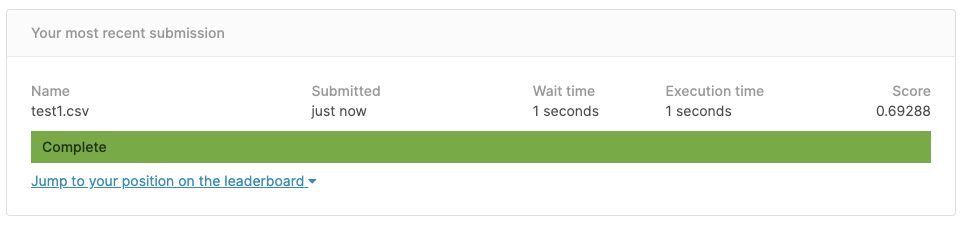

In [ ]:
predictions_base.to_csv('test1.csv', index = False)

####**Second Model**
Test on polynomial features, no features selection dataset

In [ ]:
# Importing datasets
app_train = pd.read_csv (path + '/application_train.csv')
app_test = pd.read_csv (path + '/application_test.csv')
app_test.set_index('SK_ID_CURR', inplace=True)
app_train.set_index('SK_ID_CURR', inplace=True)
print('Training data shape: ', app_train.shape)
print('Test data shape: ', app_test.shape)

Training data shape:  (307511, 121)
Test data shape:  (48744, 120)


In [ ]:
# Adding statistical features
app_train, app_test = Adding_statistical_features(app_train, app_test)

# Extracting categorical and numerical features with list comprehension
categorical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'object'])
numerical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'int64' or app_train[f].dtype == 'float64' if f != 'TARGET'])

print('Training data shape: ', app_train.shape)
print('Test data shape: ', app_test.shape)

Training data shape:  (307511, 123)
Test data shape:  (48744, 122)


In [ ]:
# Showing missing data
missing_table_train, missing_table_test = missing_values_table(app_train), missing_values_table(app_test)
missing_table_train.head(10)

,Total_mis_val,Percent_mis_val
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35


In [ ]:
# Hendling missing data
app_train, app_test = HandlingMissingData(app_train, app_test, True)
missing_values_table(app_train).head(10)

Number of rows with 30 NAN:  159332
Number of rows with 35 NAN:  154440
Number of rows with 40 NAN:  151235
Number of rows with 45 NAN:  149226
Number of rows with 50 NAN:  37240
Number of rows with 30 NAN:  24334
Number of rows with 35 NAN:  23548
Number of rows with 40 NAN:  23038
Number of rows with 45 NAN:  22736
Number of rows with 50 NAN:  5239


,Total_mis_val,Percent_mis_val
TARGET,0,0.0
FLOORSMIN_MEDI,0,0.0
OBS_60_CNT_SOCIAL_CIRCLE,0,0.0
DEF_30_CNT_SOCIAL_CIRCLE,0,0.0
OBS_30_CNT_SOCIAL_CIRCLE,0,0.0
EMERGENCYSTATE_MODE,0,0.0
WALLSMATERIAL_MODE,0,0.0
TOTALAREA_MODE,0,0.0
HOUSETYPE_MODE,0,0.0
FONDKAPREMONT_MODE,0,0.0


In [ ]:
# Clustering categorical features (> 5 unique classes)
app_train, app_test, list_clustered = categorical_class_merging(app_train, app_test, categorical_features)
for var in list_clustered:
  app_train[var] = app_train[var].astype('object')
app_train[list_clustered]

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,WALLSMATERIAL_MODE
SK_ID_CURR,,,,,,,,
100002,2,0,3,0,1,3,1,3
100003,4,0,1,0,2,4,3,3
100004,2,0,3,0,1,4,3,0
100006,2,0,3,0,1,3,1,0
100007,2,0,3,0,2,4,2,0
...,...,...,...,...,...,...,...,...
456251,2,0,4,3,2,4,2,3
456252,2,1,0,0,1,4,1,3
456253,2,0,4,0,0,4,3,0


In [ ]:
# Encoding of categorical features
app_train, app_test = label_encode(app_train, app_test)
app_train, app_test = one_hot_encode(app_train, app_test)
train_labels, app_train, app_test = align_train_test(app_train, app_test)

In [ ]:
print('Train set shape: ', app_train.shape)
print('\nTest set shape: ', app_test.shape)

Train set shape:  (307511, 126)

Test set shape:  (48744, 125)


In [ ]:
# Computing correlations with target variable
correlations, abs_correlation = Correlation(app_train)
# Display correlations
print('Most Positive Correlated:\n', correlations.sort_values(ascending=True).head(15))
print('\nMost Negative Correlated:\n', correlations.sort_values(ascending=False).head(15))

Most Positive Correlated:
 EXT_SOURCE_2                           -0.160303
EXT_SOURCE_3                           -0.157397
EXT_SOURCE_1                           -0.099152
NAME_EDUCATION_TYPE_Higher education   -0.056593
DAYS_EMPLOYED                          -0.044932
AMT_GOODS_PRICE                        -0.039628
REGION_POPULATION_RELATIVE             -0.037227
NAME_CONTRACT_TYPE                     -0.030896
AMT_CREDIT                             -0.030369
FLOORSMAX_AVG                          -0.029145
FLOORSMAX_MEDI                         -0.028989
FLOORSMAX_MODE                         -0.028631
FLAG_DOCUMENT_6                        -0.028602
HOUR_APPR_PROCESS_START                -0.024166
FLAG_PHONE                             -0.023806
Name: TARGET, dtype: float64

Most Negative Correlated:
 DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.05

In [ ]:
# Adding polynomial terms from most correlated features
pp_train, pp_test = adding_polyonomials(app_train, app_test, 3, abs_correlation.index)
pp_train

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_1,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3^2,EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1^2,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^2,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 EXT_SOURCE_1,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_1^2,EXT_SOURCE_2 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 EXT_SOURCE_1,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 EXT_SOURCE_1^2,EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_1 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY^2,DAYS_BIRTH^3,DAYS_BIRTH^2 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY^2,REGION_RATING_CLIENT_W_CITY^3
0,0.262949,0.139376,0.083037,-9461.0,2.0,0.069142,0.036649,0.021834,-2487.756636,0.525897,0.019426,0.011573,-1318.634256,0.278752,0.006895,-785.612748,0.166074,89510521.0,-18922.0,4.0,0.018181,0.009637,0.005741,-654.152107,0.138284,0.005108,0.003043,-346.733022,0.073297,0.001813,-206.575767,0.043669,2.353667e+07,-4975.513272,1.051794,0.002707,0.001613,-183.785678,0.038851,0.000961,-109.495390,0.023147,1.247560e+07,-2637.268511,0.557503,0.000573,-65.234900,0.013790,7.432682e+06,-1571.225497,0.332148,-8.468590e+11,179021042.0,-37844.0,8.0
1,0.622246,0.510853,0.311267,-16765.0,1.0,0.387190,0.317876,0.193685,-10431.950422,0.622246,0.260971,0.159012,-8564.448972,0.510853,0.096887,-5218.396475,0.311267,281065225.0,-16765.0,1.0,0.240927,0.197797,0.120520,-6491.237078,0.387190,0.162388,0.098944,-5329.192190,0.317876,0.060288,-3247.125160,0.193685,1.748916e+08,-10431.950422,0.622246,0.133318,0.081232,-4375.173647,0.260971,0.049495,-2665.833005,0.159012,1.435830e+08,-8564.448972,0.510853,0.030158,-1624.316241,0.096887,8.748642e+07,-5218.396475,0.311267,-4.712058e+12,281065225.0,-16765.0,1.0
2,0.555912,0.729567,0.502130,-19046.0,2.0,0.309038,0.405575,0.279140,-10587.901540,1.111824,0.532268,0.366337,-13895.327191,1.459133,0.252134,-9563.564279,1.004260,362750116.0,-38092.0,4.0,0.171798,0.225464,0.155177,-5885.942404,0.618076,0.295894,0.203651,-7724.580288,0.811150,0.140165,-5316.500943,0.558280,2.016572e+08,-21175.803081,2.223648,0.388325,0.267267,-10137.567875,1.064535,0.183949,-6977.257942,0.732674,2.646504e+08,-27790.654382,2.918267,0.126604,-4802.150673,0.504269,1.821476e+08,-19127.128557,2.008519,-6.908939e+12,725500232.0,-76184.0,8.0
3,0.650442,0.510853,0.502130,-19005.0,2.0,0.423074,0.332280,0.326606,-12361.644326,1.300883,0.260971,0.256514,-9708.759482,1.021706,0.252134,-9542.976957,1.004260,361190025.0,-38010.0,4.0,0.275185,0.216129,0.212438,-8040.528832,0.846149,0.169746,0.166848,-6314.981929,0.664560,0.163999,-6207.150063,0.653212,2.349331e+08,-24723.288652,2.601767,0.133318,0.131041,-4959.747997,0.521941,0.128804,-4875.057512,0.513029,1.845150e+08,-19417.518964,2.043412,0.126604,-4791.813165,0.504269,1.813643e+08,-19085.953913,2.008519,-6.864416e+12,722380050.0,-76020.0,8.0
4,0.322738,0.510853,0.502130,-19932.0,2.0,0.104160,0.164872,0.162057,-6432.819536,0.645

In [ ]:
# Computing correlation between polynomials terms and target variable
pp_corr = pp_train.corrwith(app_train['TARGET']).sort_values(ascending=False)

print('Most negative correlated polynomials with TARGET variable: \n')
print(pp_corr[:10], '\n\n')


print('\nMost positive correlated polynomials with TARGET variable: \n')
print(pp_corr[-10:])

Most negative correlated polynomials with TARGET variable: 

EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY    0.005444
EXT_SOURCE_3^2 DAYS_BIRTH                              0.004951
DAYS_BIRTH REGION_RATING_CLIENT_W_CITY^2               0.004643
EXT_SOURCE_3 DAYS_BIRTH                                0.003916
DAYS_BIRTH REGION_RATING_CLIENT_W_CITY                 0.003888
EXT_SOURCE_1 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY    0.002953
EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH                   0.002746
EXT_SOURCE_2 EXT_SOURCE_1^2                            0.002168
EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY    0.002068
EXT_SOURCE_2^2 EXT_SOURCE_1                            0.001682
dtype: float64 



Most positive correlated polynomials with TARGET variable: 

EXT_SOURCE_3                                            -0.004196
REGION_RATING_CLIENT_W_CITY^2                           -0.004244
EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY^2              -0.004421
REGION_RATING_CLIENT_

In [ ]:
# Merging polynomial dataset with the original ones
app_train_poly, app_test_poly = Merging_polynomials_and_interactions(app_train, app_test, pp_train, pp_test)
# Printing new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 181)
Testing data with polynomial features shape:   (48744, 180)


In [ ]:
# Computing the variables importance with RandomForestClassifier
variable_importance = Selecting_variables(app_train_poly, 5)
print('Representing ranking of feature importances and correlations (with correlations in absolute value) \n')
abs(variable_importance).sort_values(by='Importances', ascending=False).iloc[:10]

Write 'T' if you want the feature' importance plot:  T


None
Representing ranking of feature importances and correlations (with correlations in absolute value) 



,Importances,Correlations
EXT_SOURCE_2 EXT_SOURCE_3 EXT_SOURCE_1,0.442112,0.189593
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,0.158752,0.181417
EXT_SOURCE_2 EXT_SOURCE_3^2,0.132512,0.171729
EXT_SOURCE_2 EXT_SOURCE_3,0.081064,0.194235
EXT_SOURCE_2^2 EXT_SOURCE_3,0.022203,0.176589
EXT_SOURCE_3 EXT_SOURCE_1^2,0.014296,0.139051
NAME_EDUCATION_TYPE_Higher education,0.010441,0.056593
EXT_SOURCE_1^2 DAYS_BIRTH,0.010375,0.097402
EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH,0.007560,0.152403
EXT_SOURCE_3^2 EXT_SOURCE_1,0.007165,0.151139


In [ ]:
# Scaling Data
train_scaled, test_scaled = scaling(app_train_poly, app_test_poly)
train_scaled.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY_x,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1_x,EXT_SOURCE_2_x,EXT_SOURCE_3_x,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^2,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 EXT_SOURCE_1,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_1^2,EXT_SOURCE_2 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 EXT_SOURCE_1,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 EXT_SOURCE_1^2,EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_1 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY^2,DAYS_BIRTH^3,DAYS_BIRTH^2 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY^2,REGION_RATING_CLIENT_W_CITY^3
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.0,1.0,0.0,1.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,3.545254,1.422203,0.046749,1.000035,1.000098,0.001456,1.0,1.0,0.0,1.0,1.0,0.0,-0.052632,-0.25,-0.25,0.018904,0.0,0.0,0.0,0.0,0.0,0.0,0.060801,0.359699,0.172563,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,...,1.005651,0.013770,-0.096629,1.113016,-0.078125,0.046539,0.027671,0.015288,1.000058,0.028752,0.013204,0.007954,1.000058,0.017457,0.003622,1.000055,0.009161,-1.897000e-08,1.000016,0.017763,0.005232,0.003320,1.000052,0.006697,0.001763,1.000058,0.004279,-0.000058,1.000088,0.008501,0.000712,1.000137,0.001832,-0.001883,1.003038,0.002651,1.026859,-0.031912,1.035033,-0.028107
100003,0.0,0.0,0.0,0.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,0.619326,1.422180,0.046749,1.000039,1.000133,0.001456,1.0,1.0,0.0,1.0,1.0,0.0,-0.049861,-0.50,-0.50,0.020794,0.0,0.0,0.0,0.0,0.0,0.0,0.314689,0.851197,0.635816,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,...,1.005643,0.032159,-0.096629,1.113016,-0.125000,0.616723,0.567955,0.320925,1.000037,0.080504,0.419764,0.258602,1.000041,0.075706,0.120454,1.000046,0.040631,-1.838756e-08,1.000014,0.010509,0.257639,0.167203,1.000041,0.044988,0.090864,1.000051,0.029495,-0.000058,1.000086,0.007783,0.037879,1.000134,0.013577,-0.001883,1.003037,0.002360,1.026859,-0.031912,1.035033,-0.038462
100004,1.0,1.0,1.0,1.0,0.00000,-0.000219,-0.011236,-0.0063,-0.010101,1.863900,1.422173,0.046749,1.000034,1.000090,0.003140,1.0,1.0,1.0,1.0,1.0,0.0,-0.052632,-0.25,-0.25,0.017013,0.0,0.0,0.0,0.0,0.0,0.0,0.527009,0.760456,0.908564,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,1.005635,0.119929,-0.096629,1.113012,-0.078125,0.439767,0.647398,0.413214,1.000039,0.128510,0.764870,0.532265,1.000032,0.193185,0.280047,1.000039,0.117114,-1.828456e-08,1.000011,0.037553,0.750446,0.550130,1.000025,0.183513,0.337701,1

In [ ]:
# Splitting test_set in test and validation
from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(train_scaled,train_labels, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_validation.shape)

(246008, 181)
(61503, 181)


In [ ]:
# Traning, Tuning and Predicting
predictions_base, search_res_base, feat_imp_base = classify(train_scaled.drop('TARGET', axis = 1).copy(),
                                                             test_scaled.copy(),
                                                             train_labels,
                                                             classifier = 'lgbm',
                                                             cv = 5,
                                                             param_grid = param_grid_lgbm,
                                                             n_jobs = 1)

for par, score in zip(search_res_base['params'], search_res_base['mean_test_score']) :
    print(f"Config: {par} -- score: {score}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  26.3s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s


[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  26.9s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  25.6s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  25.4s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  25.2s
[CV] clf__max_depth=10, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=10, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  25.3s
[CV] clf__max_depth=10, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=10, clf__metric=auc, clf__n_estimators=15

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.4min finished


Config: {'clf__max_depth': 7, 'clf__metric': 'auc', 'clf__n_estimators': 150, 'clf__objective': 'binary'} -- score: 0.7638644241455614
Config: {'clf__max_depth': 10, 'clf__metric': 'auc', 'clf__n_estimators': 150, 'clf__objective': 'binary'} -- score: 0.7638644241455614


In [ ]:
predictions_base.to_csv('test2.csv', index = False)

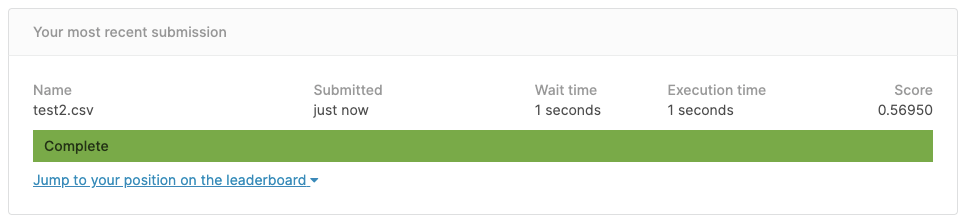

####**Third Model**
Test on polynomial features and features selection dataset


In [ ]:
# Importing datasets
app_train = pd.read_csv (path + '/application_train.csv')
app_test = pd.read_csv (path + '/application_test.csv')
app_test.set_index('SK_ID_CURR', inplace=True)
app_train.set_index('SK_ID_CURR', inplace=True)

In [ ]:
# Adding statistical features
app_train, app_test = Adding_statistical_features(app_train, app_test)

# Extracting categorical and numerical features with list comprehension
categorical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'object'])
numerical_features = np.array([f for f in app_train.columns if app_train[f].dtype == 'int64' or app_train[f].dtype == 'float64' if f != 'TARGET'])
print('Training data shape: ', app_train.shape)
print('Test data shape: ', app_test.shape)

Training data shape:  (307511, 123)
Test data shape:  (48744, 122)


In [ ]:
# Showing missing data
missing_table_train, missing_table_test = missing_values_table(app_train), missing_values_table(app_test)
missing_table_train.head(10)

,Total_mis_val,Percent_mis_val
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35


In [ ]:
# Hendling missing data
app_train, app_test = HandlingMissingData(app_train, app_test, True) 
missing_values_table(app_train).head(10)

Number of rows with 30 NAN:  159332
Number of rows with 35 NAN:  154440
Number of rows with 40 NAN:  151235
Number of rows with 45 NAN:  149226
Number of rows with 50 NAN:  37240
Number of rows with 30 NAN:  24334
Number of rows with 35 NAN:  23548
Number of rows with 40 NAN:  23038
Number of rows with 45 NAN:  22736
Number of rows with 50 NAN:  5239


,Total_mis_val,Percent_mis_val
TARGET,0,0.0
FLOORSMIN_MEDI,0,0.0
OBS_60_CNT_SOCIAL_CIRCLE,0,0.0
DEF_30_CNT_SOCIAL_CIRCLE,0,0.0
OBS_30_CNT_SOCIAL_CIRCLE,0,0.0
EMERGENCYSTATE_MODE,0,0.0
WALLSMATERIAL_MODE,0,0.0
TOTALAREA_MODE,0,0.0
HOUSETYPE_MODE,0,0.0
FONDKAPREMONT_MODE,0,0.0


In [ ]:
# Clustering categorical features (>5 uniques classes)
app_train, app_test, list_clustered = categorical_class_merging(app_train, app_test, categorical_features)
for var in list_clustered:
  app_train[var] = app_train[var].astype('object')
app_train[list_clustered]

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,WALLSMATERIAL_MODE
SK_ID_CURR,,,,,,,,
100002,4,0,0,2,1,0,1,3
100003,1,0,3,2,0,3,4,3
100004,4,0,0,2,1,3,4,0
100006,4,0,0,2,1,0,1,0
100007,4,0,0,2,0,3,2,0
...,...,...,...,...,...,...,...,...
456251,4,0,4,3,0,3,2,3
456252,4,3,1,2,1,3,1,3
456253,4,0,4,2,2,3,4,0


In [ ]:
# Encoding categorical features
app_train, app_test = label_encode(app_train, app_test)
app_train, app_test = one_hot_encode(app_train, app_test)
train_labels, app_train, app_test = align_train_test(app_train, app_test)

In [ ]:
app_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_PERCENT,CREDIT_TERM,BINARY_NAN,SUM_NAN,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,12.061091,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,2.007889,0.060749,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1
100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,12.061091,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,0.510853,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,4.790750,0.027598,0,2,0,1,0,0,0,0,0,1,0,1,0,0,0
100004,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.000000,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.502130,0.555912,0.729567,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,2.000000,0.050000,1,48,0,0,0,0,1,0,0,1,0,1,0,0,0
100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,12.061091,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.502130,0.650442,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,2.316167,0.094941,1,56,0,0,0,0,1,0,0,1,0,1,0,0,0
100007,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,12.061091,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.502130,0.322738,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,4.222222,0.042623,1,50,0,0,0,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,12.061091,1,1,0,1,0,0,1.0,1,1,15,0,0,0,0,0,0,0.145570,0.681632,0.510853,0.20210,0.088700,0.987600,0.830000,0.0

In [ ]:
# Compunting correlation with target variable
correlations, abs_correlation = Correlation(app_train)
# Display correlations
print('Most Positive Correlated:\n', correlations.sort_values(ascending=True).head(15))
print('\nMost Negative Correlated:\n', correlations.sort_values(ascending=False).head(15))

Most Positive Correlated:
 EXT_SOURCE_2                           -0.160303
EXT_SOURCE_3                           -0.157397
EXT_SOURCE_1                           -0.099152
NAME_EDUCATION_TYPE_Higher education   -0.056593
DAYS_EMPLOYED                          -0.044932
AMT_GOODS_PRICE                        -0.039628
REGION_POPULATION_RELATIVE             -0.037227
NAME_CONTRACT_TYPE                     -0.030896
AMT_CREDIT                             -0.030369
FLOORSMAX_AVG                          -0.029145
FLOORSMAX_MEDI                         -0.028989
FLOORSMAX_MODE                         -0.028631
FLAG_DOCUMENT_6                        -0.028602
HOUR_APPR_PROCESS_START                -0.024166
FLAG_PHONE                             -0.023806
Name: TARGET, dtype: float64

Most Negative Correlated:
 DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.05

In [ ]:
# Adding polynomial terms from most correlated features
pp_train, pp_test = adding_polyonomials(app_train, app_test, 3, abs_correlation.index)
pp_train

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_1,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3^2,EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1^2,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^2,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 EXT_SOURCE_1,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_1^2,EXT_SOURCE_2 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 EXT_SOURCE_1,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 EXT_SOURCE_1^2,EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_1 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY^2,DAYS_BIRTH^3,DAYS_BIRTH^2 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY^2,REGION_RATING_CLIENT_W_CITY^3
0,0.262949,0.139376,0.083037,-9461.0,2.0,0.069142,0.036649,0.021834,-2487.756636,0.525897,0.019426,0.011573,-1318.634256,0.278752,0.006895,-785.612748,0.166074,89510521.0,-18922.0,4.0,0.018181,0.009637,0.005741,-654.152107,0.138284,0.005108,0.003043,-346.733022,0.073297,0.001813,-206.575767,0.043669,2.353667e+07,-4975.513272,1.051794,0.002707,0.001613,-183.785678,0.038851,0.000961,-109.495390,0.023147,1.247560e+07,-2637.268511,0.557503,0.000573,-65.234900,0.013790,7.432682e+06,-1571.225497,0.332148,-8.468590e+11,179021042.0,-37844.0,8.0
1,0.622246,0.510853,0.311267,-16765.0,1.0,0.387190,0.317876,0.193685,-10431.950422,0.622246,0.260971,0.159012,-8564.448972,0.510853,0.096887,-5218.396475,0.311267,281065225.0,-16765.0,1.0,0.240927,0.197797,0.120520,-6491.237078,0.387190,0.162388,0.098944,-5329.192190,0.317876,0.060288,-3247.125160,0.193685,1.748916e+08,-10431.950422,0.622246,0.133318,0.081232,-4375.173647,0.260971,0.049495,-2665.833005,0.159012,1.435830e+08,-8564.448972,0.510853,0.030158,-1624.316241,0.096887,8.748642e+07,-5218.396475,0.311267,-4.712058e+12,281065225.0,-16765.0,1.0
2,0.555912,0.729567,0.502130,-19046.0,2.0,0.309038,0.405575,0.279140,-10587.901540,1.111824,0.532268,0.366337,-13895.327191,1.459133,0.252134,-9563.564279,1.004260,362750116.0,-38092.0,4.0,0.171798,0.225464,0.155177,-5885.942404,0.618076,0.295894,0.203651,-7724.580288,0.811150,0.140165,-5316.500943,0.558280,2.016572e+08,-21175.803081,2.223648,0.388325,0.267267,-10137.567875,1.064535,0.183949,-6977.257942,0.732674,2.646504e+08,-27790.654382,2.918267,0.126604,-4802.150673,0.504269,1.821476e+08,-19127.128557,2.008519,-6.908939e+12,725500232.0,-76184.0,8.0
3,0.650442,0.510853,0.502130,-19005.0,2.0,0.423074,0.332280,0.326606,-12361.644326,1.300883,0.260971,0.256514,-9708.759482,1.021706,0.252134,-9542.976957,1.004260,361190025.0,-38010.0,4.0,0.275185,0.216129,0.212438,-8040.528832,0.846149,0.169746,0.166848,-6314.981929,0.664560,0.163999,-6207.150063,0.653212,2.349331e+08,-24723.288652,2.601767,0.133318,0.131041,-4959.747997,0.521941,0.128804,-4875.057512,0.513029,1.845150e+08,-19417.518964,2.043412,0.126604,-4791.813165,0.504269,1.813643e+08,-19085.953913,2.008519,-6.864416e+12,722380050.0,-76020.0,8.0
4,0.322738,0.510853,0.502130,-19932.0,2.0,0.104160,0.164872,0.162057,-6432.819536,0.645

In [ ]:
# Merging polynomial dataset with the orinal ones
app_train_poly, app_test_poly = Merging_polynomials_and_interactions(app_train, app_test, pp_train, pp_test)
# Printing new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 181)
Testing data with polynomial features shape:   (48744, 180)


In [ ]:
app_train_poly

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY_x,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1_x,EXT_SOURCE_2_x,EXT_SOURCE_3_x,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^2,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 EXT_SOURCE_1,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_1^2,EXT_SOURCE_2 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 EXT_SOURCE_1,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 EXT_SOURCE_1^2,EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_1 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY^2,DAYS_BIRTH^3,DAYS_BIRTH^2 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY^2,REGION_RATING_CLIENT_W_CITY^3
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,12.061091,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,...,-785.612748,0.166074,89510521.0,-18922.0,4.0,0.018181,0.009637,0.005741,-654.152107,0.138284,0.005108,0.003043,-346.733022,0.073297,0.001813,-206.575767,0.043669,2.353667e+07,-4975.513272,1.051794,0.002707,0.001613,-183.785678,0.038851,0.000961,-109.495390,0.023147,1.247560e+07,-2637.268511,0.557503,0.000573,-65.234900,0.013790,7.432682e+06,-1571.225497,0.332148,-8.468590e+11,179021042.0,-37844.0,8.0
100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,12.061091,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,0.510853,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,...,-5218.396475,0.311267,281065225.0,-16765.0,1.0,0.240927,0.197797,0.120520,-6491.237078,0.387190,0.162388,0.098944,-5329.192190,0.317876,0.060288,-3247.125160,0.193685,1.748916e+08,-10431.950422,0.622246,0.133318,0.081232,-4375.173647,0.260971,0.049495,-2665.833005,0.159012,1.435830e+08,-8564.448972,0.510853,0.030158,-1624.316241,0.096887,8.748642e+07,-5218.396475,0.311267,-4.712058e+12,281065225.0,-16765.0,1.0
100004,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.000000,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.502130,0.555912,0.729567,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,...,-9563.564279,1.004260,362750116.0,-38092.0,4.0,0.171798,0.225464,0.155177,-5885.942404,0.618076,0.295894,0.203651,-7724.580288,0.811150,0.140165,-5316.500943,0.558280,2.016572e+08,-21175.803081,2.223648,0.388325,0.267267,-10137.567875,1.064535,0.183949,-6977.257942,0.732674,2.646504e+08,-27790.654382,2.918267,0.126604,-4802.150673,0.504269,1.821476e+08,-19127.128557,

In [ ]:
# Computing variables importance with RandomForestClassifier
variable_importance = Selecting_variables(app_train_poly, 5)
print('Representing ranking of feature importances and correlations (with correlations in absolute value) \n')
abs(variable_importance).sort_values(by='Importances', ascending=False).iloc[:10]
# We extract the top 80 features most important
variables_selected = variable_importance.index[:80]

# We generate the new train and test set with only the selected features
train_selected = app_train_poly[variables_selected]
test_selected = app_test_poly[variables_selected]

Write 'T' if you want the feature' importance plot:  T


None
Representing ranking of feature importances and correlations (with correlations in absolute value) 



In [ ]:
# Scaling data
train_scaled, test_scaled = scaling(train_selected, test_selected)
train_scaled.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,EXT_SOURCE_2 EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_3 EXT_SOURCE_1^2,NAME_EDUCATION_TYPE_Higher education,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3^2 EXT_SOURCE_1,NAME_EDUCATION_TYPE_Secondary / secondary special,EXT_SOURCE_2 EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3 EXT_SOURCE_1,EXT_SOURCE_2^2 EXT_SOURCE_1,FLAG_DOCUMENT_3,EXT_SOURCE_2 EXT_SOURCE_1^2,EXT_SOURCE_1^2,CODE_GENDER,AMT_REQ_CREDIT_BUREAU_DAY,EXT_SOURCE_2 EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 EXT_SOURCE_1,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_3^2 DAYS_BIRTH,SUM_NAN,EXT_SOURCE_1_x,AMT_ANNUITY,EXT_SOURCE_3^2,AMT_REQ_CREDIT_BUREAU_HOUR,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3_y,CREDIT_TERM,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1_y,EXT_SOURCE_3_x,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^2 REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2_x,DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_2^2,EXT_SOURCE_2_y,DAYS_EMPLOYED,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY^2,CREDIT_INCOME_PERCENT,EXT_SOURCE_1^3,AMT_CREDIT,EXT_SOURCE_1 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^3,DAYS_BIRTH_y,AMT_GOODS_PRICE,OWN_CAR_AGE,EXT_SOURCE_2^3,EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1^2 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH^2,YEARS_BEGINEXPLUATATION_AVG,EXT_SOURCE_2 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY,DAYS_REGISTRATION,EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY^2,EXT_SOURCE_3^2 REGION_RATING_CLIENT_W_CITY,NAME_CONTRACT_TYPE,EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH_x,EXT_SOURCE_2^2 REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_WEEK,EXT_SOURCE_3 REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,YEARS_BUILD_AVG,REG_CITY_NOT_LIVE_CITY,FLAG_OWN_CAR,LANDAREA_MEDI,CNT_FAM_MEMBERS
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.007954,1.000058,0.013204,0.073785,0.027671,0.001763,0.0,1.000137,1.000058,0.003320,1.0,1.000055,0.018550,0.015288,1.0,0.003622,0.007555,1.0,0.000000,0.017457,0.039228,1.005651,1.000052,0.000260,0.060801,-0.0063,0.030138,0.0000,-0.001883,1.000058,-0.000058,0.005232,0.172563,3.475953,1.000043,1.000231,1.000088,0.060801,0.172563,1.035033,0.004279,-0.031912,0.359699,1.113016,-1.897000e-08,0.129383,0.359699,0.046749,0.008501,0.000222,0.000712,-0.011236,1.003038,0.013770,1.026859,1.422203,-0.010101,0.001456,0.046539,1.000016,0.001832,-0.096629,0.972200,0.009161,1.000035,0.002651,0.006697,0.0,0.079933,1.422203,0.028752,0.000000,0.038325,1.000171,1.000098,0.619200,0.0,0.0,0.037500,-0.052632
100003,0.258602,1.000041,0.419764,0.639983,0.567955,0.090864,1.0,1.000134,1.000051,0.167203,0.0,1.000046,0.255380,0.320925,1.0,0.120454,0.112377,0.0,0.000000,0.075706,0.347972,1.005643,1.000041,0.000520,0.314689,-0.0063,0.404893,0.0000,-0.001883,1.000037,-0.000058,0.257639,0.635816,0.311776,1.000024,1.000216,1.000086,0.314689,0.635816,1.035033,0.029495,-0.031912,0.851197,1.113016,-1.838756e-08,0.724536,0.851197,0.046749,0.007783,0.000610,0.037879,-0.011236,1.003037,0.032159,1.026859,1.422180,-0.010101,0.001456,0.616723,1.000014,0.013577,-0.096629,0.985100,0.040631,1.000039,0.002360,0.044988,0.0,0.094577,1.422180,0.080504,0.000000,0.070460,1.000188,1.000133,0.796000,0.0,0.0,0.013200,-0.049861
100004,0.532265,1.000032,0.764870,0.816549,0.647398,0.337701,0.0,1.000128,1.000040,0.550130,1.0,1.000039,0.588406,0.413214,0.0,0.280047,0.293208,1.0,0.000000,0.193185,0.501501,1.005635,1.000025,0.012487,0.527009,-0.0063,0.825808,0.0000,-0.001883,1.000039,-0.000058,0.750446,0.908564,2.449962,1.000024,1.000204,1.000082,0.527009,0.908564,1.035032,0.135967,-0.031912,0.760456,1.113012,-1

In [ ]:
# Traning, Tuning and Predicting
predictions_base, search_res_base, feat_imp_base = classify(train_scaled.copy(),
                                                             test_scaled.copy(),
                                                             train_labels,
                                                             classifier = 'lgbm',
                                                             cv = 5,
                                                             param_grid = param_grid_lgbm,
                                                             n_jobs = 1)

for par, score in zip(search_res_base['params'], search_res_base['mean_test_score']) :
    print(f"Config: {par} -- score: {score}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  14.4s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  14.2s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  14.1s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  14.3s
[CV] clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=7, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  14.3s
[CV] clf__max_depth=10, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=10, clf__metric=auc, clf__n_estimators=150, clf__objective=binary, total=  14.4s
[CV] clf__max_depth=10, clf__metric=auc, clf__n_estimators=150, clf__objective=binary 
[CV]  clf__max_depth=10, clf__metric=auc, clf__n_estimators=15

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


Config: {'clf__max_depth': 7, 'clf__metric': 'auc', 'clf__n_estimators': 150, 'clf__objective': 'binary'} -- score: 0.7635300062715236
Config: {'clf__max_depth': 10, 'clf__metric': 'auc', 'clf__n_estimators': 150, 'clf__objective': 'binary'} -- score: 0.7635300062715236


In [ ]:
predictions_base.to_csv('test3.csv', index = False)

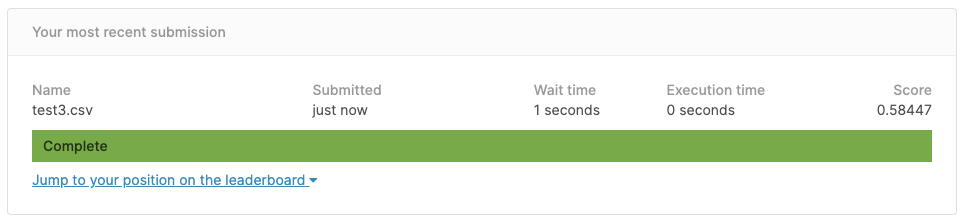